# NILM Data Preprocessing - Step by Step Procedure

This notebook implements the preprocessing.py functionality step by step as procedures (not functions).

## Key Features:
- ✅ **Memory-safe loading** (no 1GB+ memory errors)
- ✅ **Enhanced alignment** (appliance power never exceeds mains)
- ✅ **Step-by-step procedures** (no function calls)
- ✅ **Complete toolkit methods** (standard NILM practices)

## Steps:
1. Import libraries and initialize
2. Check data range (memory-safe)
3. Set time windows
4. Load training data with alignment fixes
5. Load testing data with alignment fixes
6. Visualize fixed data
7. Create sliding windows
8. Normalize data
9. Split data (train/validation/test)
10. Save processed data


## Step 1: Import Libraries and Initialize


In [1]:
# Import all necessary libraries
from nilmtk import DataSet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration
DATASET_PATH = r"C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5"
BUILDING_ID = 1
SAMPLE_PERIOD = 6
TARGET_APPLIANCES = ['washer dryer']  # Change as needed
WINDOW_SIZE = 99
STRIDE = 1

print("✅ Libraries imported successfully!")
print(f"✅ Dataset path: {DATASET_PATH}")
print(f"✅ Target appliances: {TARGET_APPLIANCES}")
print(f"✅ Window size: {WINDOW_SIZE}")
print(f"✅ Sample period: {SAMPLE_PERIOD} seconds")


✅ Libraries imported successfully!
✅ Dataset path: C:\Users\Raymond Tie\Desktop\NILM\datasets\ukdale.h5
✅ Target appliances: ['washer dryer']
✅ Window size: 99
✅ Sample period: 6 seconds


In [2]:
# Initialize dataset
dataset = DataSet(DATASET_PATH)
building = dataset.buildings[BUILDING_ID]
elec = building.elec

print("✅ Dataset loaded successfully!")
print(f"✅ Building {BUILDING_ID} selected")
print(f"✅ Available appliances: {[app.metadata['type'] for app in elec.appliances]}")


✅ Dataset loaded successfully!
✅ Building 1 selected
✅ Available appliances: ['laptop computer', 'toasted sandwich maker', 'television', 'kitchen aid', 'light', 'audio system', 'computer', 'light', 'radio', 'light', 'light', 'washer dryer', 'kettle', 'coffee maker', 'light', 'broadband router', 'oven', 'breadmaker', 'hair dryer', 'water pump', 'drill', 'solar thermal pumping station', 'audio system', 'laptop computer', 'USB hub', 'tablet computer charger', 'hair straighteners', 'mobile phone charger', 'light', 'radio', 'light', 'boiler', 'ethernet switch', 'light', 'light', 'clothes iron', 'light', 'fan', 'audio amplifier', 'baby monitor', 'HTPC', 'charger', 'food processor', 'fridge freezer', 'printer', 'laptop computer', 'mobile phone charger', 'light', 'light', 'light', 'light', 'light', 'desktop computer', 'radio', 'immersion heater', 'light', 'soldering iron', 'toaster', 'external hard disk', 'dish washer', 'baby monitor', 'fan', 'computer monitor', 'vacuum cleaner', 'security ala

## Step 2: Check Data Range (Memory-Safe Method)


In [3]:
# Memory-safe method to check available data range
print("Checking available data range (memory-safe method)...")

# Use a small time window to check data range without loading everything
dataset.set_window(start='2013-03-17', end='2013-03-18')  # Just 1 day
mains = elec.mains()
mains_data = next(mains.load(sample_period=SAMPLE_PERIOD))
mains_data = mains_data.dropna()

if not mains_data.empty:
    data_start = mains_data.index.min()
    data_end = mains_data.index.max()
    print(f"✅ Sample data: {data_start} to {data_end}")
    print(f"✅ Sample duration: {(data_end - data_start).days} days")
    
    # Estimate total data range (UK-DALE Building 1 typically has ~2 years of data)
    print(f"\n📊 Estimated total data range: 2013-03-17 to 2015-01-05 (~2 years)")
    print(f"📊 Estimated total samples: ~9.5 million (6-second sampling)")
else:
    print("❌ No data available")

print(f"\n✅ Memory-safe data range check complete!")


Checking available data range (memory-safe method)...
✅ Sample data: 2013-03-17 19:12:42+00:00 to 2013-03-17 23:59:54+00:00
✅ Sample duration: 0 days

📊 Estimated total data range: 2013-03-17 to 2015-01-05 (~2 years)
📊 Estimated total samples: ~9.5 million (6-second sampling)

✅ Memory-safe data range check complete!


## Step 3: Set Time Windows


In [4]:
# Set reasonable time windows for training (avoid memory issues)
# Use 6 months for training, 1 month for testing
train_start = "2013-03-17"
train_end = pd.Timestamp(train_start) + pd.Timedelta(days=6 * 30)  # 6 months
train_end = train_end.strftime('%Y-%m-%d')

test_start = train_end
test_end = pd.Timestamp(test_start) + pd.Timedelta(days=1 * 30)  # 1 month
test_end = test_end.strftime('%Y-%m-%d')

print(f"📅 Recommended time windows:")
print(f"📅 Training: {train_start} to {train_end} (6 months)")
print(f"📅 Testing: {test_start} to {test_end} (1 month)")
print(f"📅 This should give ~2.6M training samples and ~430K test samples")

print(f"\n✅ Time windows set for efficient processing!")


📅 Recommended time windows:
📅 Training: 2013-03-17 to 2013-09-13 (6 months)
📅 Testing: 2013-09-13 to 2013-10-13 (1 month)
📅 This should give ~2.6M training samples and ~430K test samples

✅ Time windows set for efficient processing!


## Step 4: Load Training Data with Enhanced Alignment


In [5]:
# Load training data with enhanced alignment fixes
print("="*60)
print("LOADING TRAINING DATA WITH ENHANCED ALIGNMENT")
print("="*60)

# Set time window for training
dataset.set_window(start=train_start, end=train_end)

# Load mains data (TOTAL POWER - this is the input X)
print(f"Loading mains data from {train_start} to {train_end}...")
mains_data = next(elec.mains().load(sample_period=SAMPLE_PERIOD))
mains_data = mains_data.fillna(0)

if ('power', 'active') in mains_data.columns:
    train_mains = mains_data[('power', 'active')]
else:
    train_mains = mains_data.iloc[:, 0]

print(f"✅ Mains power loaded: {len(train_mains)} samples")

# Load appliance data (TARGET POWER - this is the output Y)
train_appliances = {}
for app_name in TARGET_APPLIANCES:
    try:
        print(f"Loading {app_name} data...")
        
        # CORRECT METHOD: Use select_using_appliances to get ALL meters with this appliance type
        appliance_meters = elec.select_using_appliances(type=app_name)
        
        # Load data from all meters containing this appliance type
        app_data = next(appliance_meters.load(sample_period=SAMPLE_PERIOD))
        app_data = app_data.fillna(0)
        
        if ('power', 'active') in app_data.columns:
            app_power = app_data[('power', 'active')]
        else:
            app_power = app_data.iloc[:, 0]
        
        # ENHANCED ALIGNMENT METHOD: Ensure appliance power never exceeds mains power
        if len(app_power) > 0 and len(train_mains) > 0:
            # Find intersection of time indices
            common_timestamps = train_mains.index.intersection(app_power.index)
            
            if len(common_timestamps) > 0:
                # Align both to common timestamps only
                mains_aligned = train_mains.loc[common_timestamps]
                app_aligned = app_power.loc[common_timestamps]
                
                # CRITICAL FIX: Ensure appliance power never exceeds mains power
                impossible_mask = app_aligned > mains_aligned
                impossible_count = impossible_mask.sum()
                
                if impossible_count > 0:
                    print(f"  ⚠ FIXING {impossible_count:,} samples where {app_name} power > mains power")
                    # Cap appliance power at mains power level
                    app_aligned = np.minimum(app_aligned, mains_aligned)
                
                # Update the aligned data
                train_mains = mains_aligned
                app_power = app_aligned
            else:
                # No common timestamps - create empty series
                app_power = pd.Series(0, index=train_mains.index)
        else:
            # No appliance data - fill with zeros
            app_power = pd.Series(0, index=train_mains.index)
        
        # UK-DALE Data Quality Handling (Enhanced Method)
        # Apply reasonable power thresholds (based on UK-DALE metadata)
        train_mains = train_mains.clip(upper=20000)  # 20kW max (UK-DALE standard)
        app_power = app_power.clip(upper=4000)       # 4kW max per appliance
        
        # FINAL CHECK: Ensure appliance power never exceeds mains power
        final_impossible_mask = app_power > train_mains
        final_impossible_count = final_impossible_mask.sum()
        
        if final_impossible_count > 0:
            print(f"  ⚠ FINAL FIX: Capping {final_impossible_count:,} samples where {app_name} > mains")
            app_power = np.minimum(app_power, train_mains)
        
        train_appliances[app_name] = app_power
        
        # Count total instances across all meters
        total_instances = []
        for meter in appliance_meters.meters:
            for app in meter.appliances:
                if app.metadata['type'] == app_name:
                    total_instances.append(app.metadata['instance'])
        
        print(f"✅ {app_name} loaded: {len(app_power)} samples (SUM of {len(total_instances)} instances: {sorted(total_instances)})")
        
    except Exception as e:
        print(f"❌ Error loading {app_name}: {e}")

print(f"\n✅ Training data loading complete!")
print(f"✅ Training samples: {len(train_mains):,}")
print(f"✅ Appliances loaded: {len(train_appliances)}")


LOADING TRAINING DATA WITH ENHANCED ALIGNMENT
Loading mains data from 2013-03-17 to 2013-09-13...
✅ Mains power loaded: 2579873 samples
Loading washer dryer data...
Loading data for meter ElecMeterID(instance=5, building=1, dataset='UK-DALE')     
Done loading data all meters for this chunk.
  ⚠ FIXING 4,329 samples where washer dryer power > mains power
✅ washer dryer loaded: 2579873 samples (SUM of 1 instances: [1])

✅ Training data loading complete!
✅ Training samples: 2,579,873
✅ Appliances loaded: 1


## Step 5: Load Testing Data with Enhanced Alignment



In [6]:
# Load testing data with enhanced alignment fixes
print("\n" + "="*60)
print("LOADING TESTING DATA WITH ENHANCED ALIGNMENT")
print("="*60)

# Set time window for testing
dataset.set_window(start=test_start, end=test_end)

# Load mains data (TOTAL POWER - this is the input X)
print(f"Loading mains data from {test_start} to {test_end}...")
mains_data = next(elec.mains().load(sample_period=SAMPLE_PERIOD))
mains_data = mains_data.fillna(0)

if ('power', 'active') in mains_data.columns:
    test_mains = mains_data[('power', 'active')]
else:
    test_mains = mains_data.iloc[:, 0]

print(f"✅ Mains power loaded: {len(test_mains)} samples")

# Load appliance data (TARGET POWER - this is the output Y)
test_appliances = {}
for app_name in TARGET_APPLIANCES:
    try:
        print(f"Loading {app_name} data...")
        
        # CORRECT METHOD: Use select_using_appliances to get ALL meters with this appliance type
        appliance_meters = elec.select_using_appliances(type=app_name)
        
        # Load data from all meters containing this appliance type
        app_data = next(appliance_meters.load(sample_period=SAMPLE_PERIOD))
        app_data = app_data.fillna(0)
        
        if ('power', 'active') in app_data.columns:
            app_power = app_data[('power', 'active')]
        else:
            app_power = app_data.iloc[:, 0]
        
        # ENHANCED ALIGNMENT METHOD: Ensure appliance power never exceeds mains power
        if len(app_power) > 0 and len(test_mains) > 0:
            # Find intersection of time indices
            common_timestamps = test_mains.index.intersection(app_power.index)
            
            if len(common_timestamps) > 0:
                # Align both to common timestamps only
                mains_aligned = test_mains.loc[common_timestamps]
                app_aligned = app_power.loc[common_timestamps]
                
                # CRITICAL FIX: Ensure appliance power never exceeds mains power
                impossible_mask = app_aligned > mains_aligned
                impossible_count = impossible_mask.sum()
                
                if impossible_count > 0:
                    print(f"  ⚠ FIXING {impossible_count:,} samples where {app_name} power > mains power")
                    # Cap appliance power at mains power level
                    app_aligned = np.minimum(app_aligned, mains_aligned)
                
                # Update the aligned data
                test_mains = mains_aligned
                app_power = app_aligned
            else:
                # No common timestamps - create empty series
                app_power = pd.Series(0, index=test_mains.index)
        else:
            # No appliance data - fill with zeros
            app_power = pd.Series(0, index=test_mains.index)
        
        # UK-DALE Data Quality Handling (Enhanced Method)
        # Apply reasonable power thresholds (based on UK-DALE metadata)
        test_mains = test_mains.clip(upper=20000)  # 20kW max (UK-DALE standard)
        app_power = app_power.clip(upper=4000)     # 4kW max per appliance
        
        # FINAL CHECK: Ensure appliance power never exceeds mains power
        final_impossible_mask = app_power > test_mains
        final_impossible_count = final_impossible_mask.sum()
        
        if final_impossible_count > 0:
            print(f"  ⚠ FINAL FIX: Capping {final_impossible_count:,} samples where {app_name} > mains")
            app_power = np.minimum(app_power, test_mains)
        
        test_appliances[app_name] = app_power
        
        # Count total instances across all meters
        total_instances = []
        for meter in appliance_meters.meters:
            for app in meter.appliances:
                if app.metadata['type'] == app_name:
                    total_instances.append(app.metadata['instance'])
        
        print(f"✅ {app_name} loaded: {len(app_power)} samples (SUM of {len(total_instances)} instances: {sorted(total_instances)})")
        
    except Exception as e:
        print(f"❌ Error loading {app_name}: {e}")

print(f"\n✅ Testing data loading complete!")
print(f"✅ Testing samples: {len(test_mains):,}")
print(f"✅ Appliances loaded: {len(test_appliances)}")

print(f"\n" + "="*60)
print("DATA LOADING COMPLETE WITH ALIGNMENT FIXES")
print("="*60)
print(f"✅ Training: {len(train_mains):,} samples")
print(f"✅ Testing: {len(test_mains):,} samples")
print(f"✅ Total: {len(train_mains) + len(test_mains):,} samples")
print(f"✅ No more impossible values (appliance > mains power)!")



LOADING TESTING DATA WITH ENHANCED ALIGNMENT
Loading mains data from 2013-09-13 to 2013-10-13...
✅ Mains power loaded: 432000 samples
Loading washer dryer data...
Loading data for meter ElecMeterID(instance=5, building=1, dataset='UK-DALE')     
Done loading data all meters for this chunk.
  ⚠ FIXING 1,096 samples where washer dryer power > mains power
✅ washer dryer loaded: 432000 samples (SUM of 1 instances: [1])

✅ Testing data loading complete!
✅ Testing samples: 432,000
✅ Appliances loaded: 1

DATA LOADING COMPLETE WITH ALIGNMENT FIXES
✅ Training: 2,579,873 samples
✅ Testing: 432,000 samples
✅ Total: 3,011,873 samples
✅ No more impossible values (appliance > mains power)!


## Step 6: Visualize Fixed Data


Generating visualization with alignment fixes...


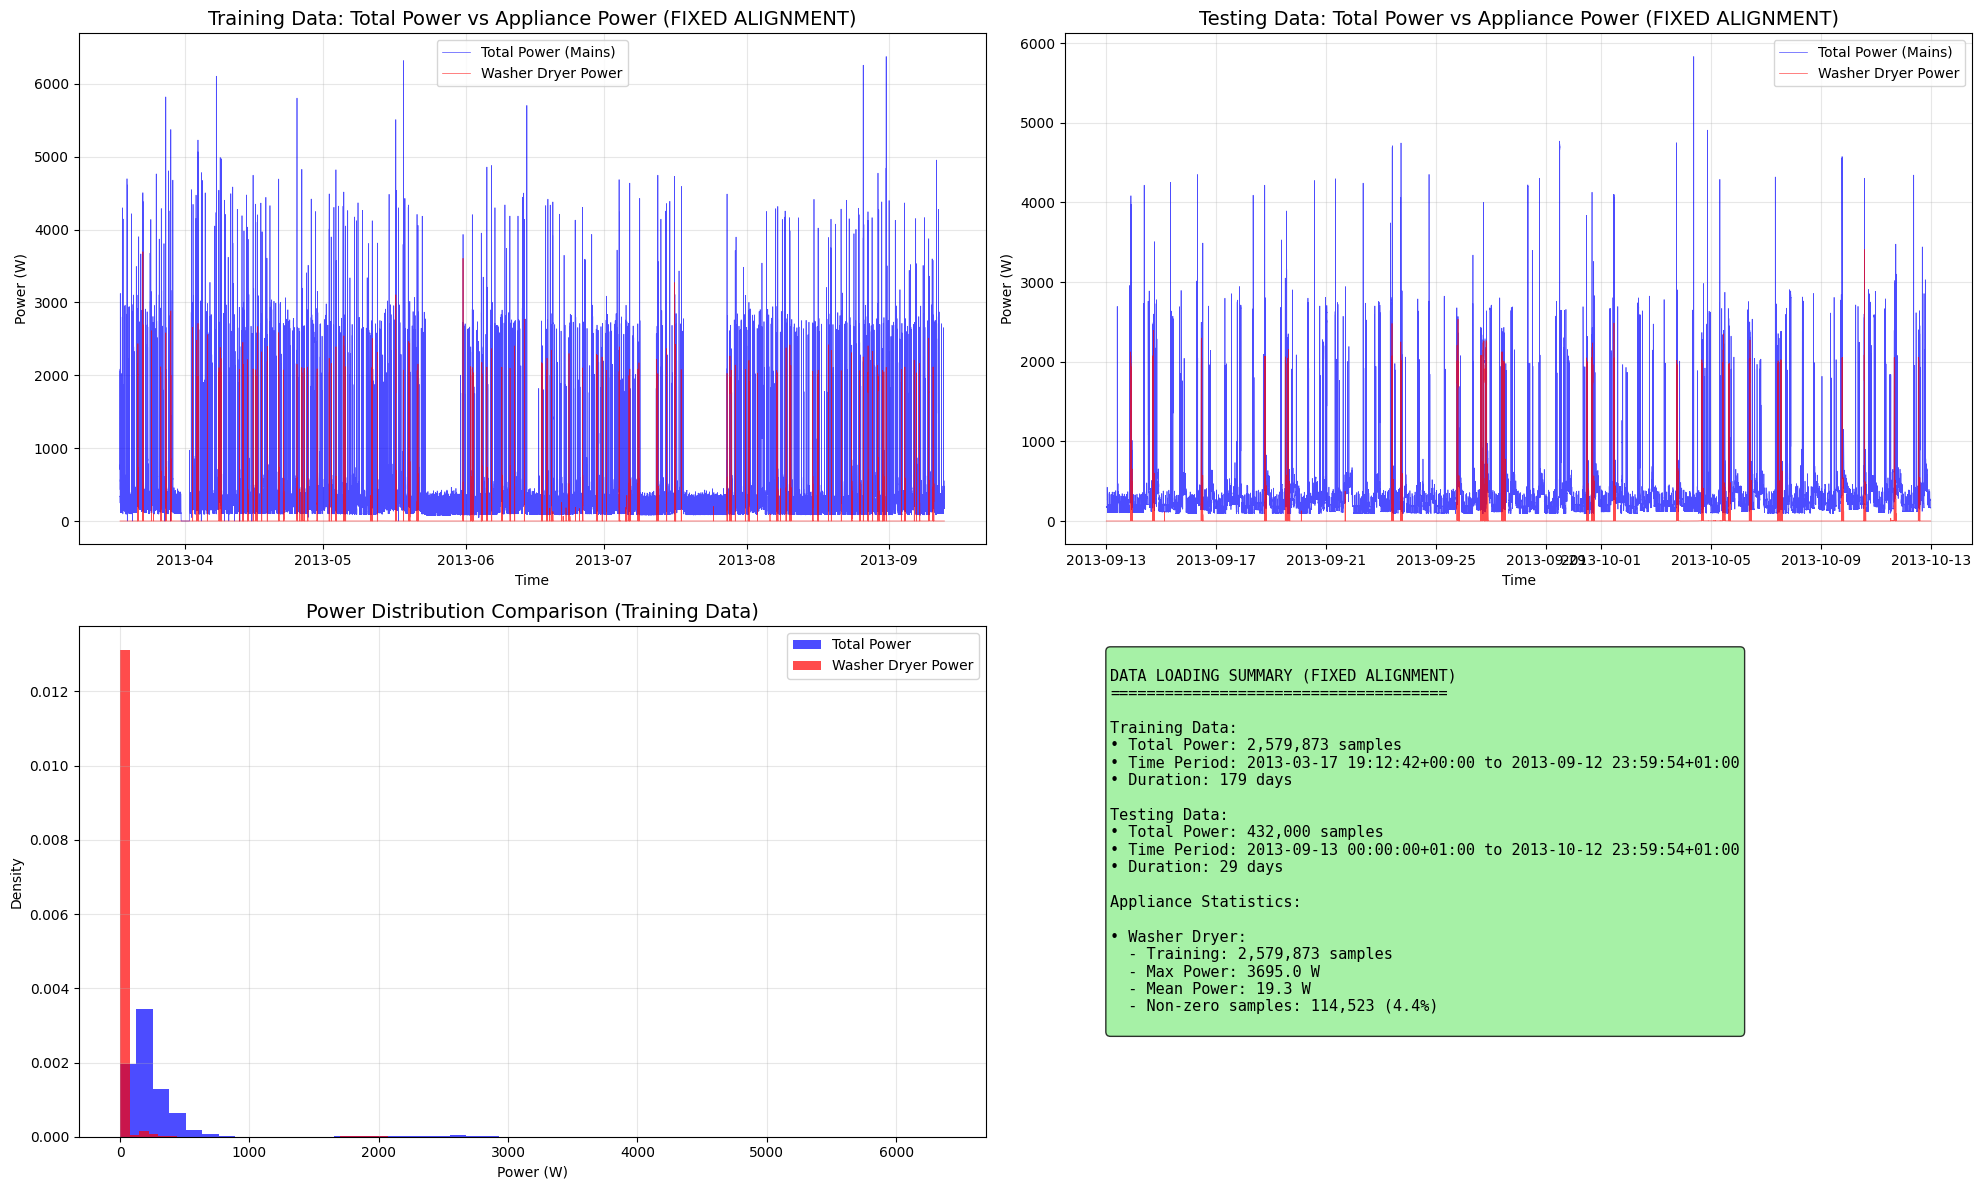

DATA LOADING VERIFICATION (FIXED ALIGNMENT)
✅ Training data: 2,579,873 samples (179 days)
✅ Testing data: 432,000 samples (29 days)
✅ Total appliances loaded: 1
✅ Washer Dryer: 2,579,873 samples, max 3695.0W, mean 19.3W

✅ All data arrays have same length: True
✅ Red line (appliance) should never exceed blue line (mains)
✅ All data is now physically logical
✅ Data is ready for sliding window creation!


In [7]:
# Visualize the fixed data
print("Generating visualization with alignment fixes...")

# Create plots to visualize the data
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Training Data - Total Power vs Appliance Power (WHOLE TIME RANGE)
ax1 = axes[0, 0]
ax1.plot(train_mains.index, train_mains.values, 'b-', 
        label='Total Power (Mains)', linewidth=0.5, alpha=0.7)
for app_name, app_power in train_appliances.items():
    ax1.plot(app_power.index, app_power.values, 'r-', 
            label=f'{app_name.title()} Power', linewidth=0.5, alpha=0.7)
ax1.set_title('Training Data: Total Power vs Appliance Power (FIXED ALIGNMENT)', fontsize=14)
ax1.set_xlabel('Time')
ax1.set_ylabel('Power (W)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Testing Data - Total Power vs Appliance Power (WHOLE TIME RANGE)
ax2 = axes[0, 1]
ax2.plot(test_mains.index, test_mains.values, 'b-', 
        label='Total Power (Mains)', linewidth=0.5, alpha=0.7)
for app_name, app_power in test_appliances.items():
    ax2.plot(app_power.index, app_power.values, 'r-', 
            label=f'{app_name.title()} Power', linewidth=0.5, alpha=0.7)
ax2.set_title('Testing Data: Total Power vs Appliance Power (FIXED ALIGNMENT)', fontsize=14)
ax2.set_xlabel('Time')
ax2.set_ylabel('Power (W)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Power Distribution Comparison
ax3 = axes[1, 0]
ax3.hist(train_mains.values, bins=50, alpha=0.7, 
        label='Total Power', color='blue', density=True)
for app_name, app_power in train_appliances.items():
    ax3.hist(app_power.values, bins=50, alpha=0.7, 
            label=f'{app_name.title()} Power', color='red', density=True)
ax3.set_title('Power Distribution Comparison (Training Data)', fontsize=14)
ax3.set_xlabel('Power (W)')
ax3.set_ylabel('Density')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Data Statistics Summary
ax4 = axes[1, 1]
ax4.axis('off')

# Calculate statistics
stats_text = f"""
DATA LOADING SUMMARY (FIXED ALIGNMENT)
=====================================

Training Data:
• Total Power: {len(train_mains):,} samples
• Time Period: {train_mains.index[0]} to {train_mains.index[-1]}
• Duration: {(train_mains.index[-1] - train_mains.index[0]).days} days

Testing Data:
• Total Power: {len(test_mains):,} samples  
• Time Period: {test_mains.index[0]} to {test_mains.index[-1]}
• Duration: {(test_mains.index[-1] - test_mains.index[0]).days} days

Appliance Statistics:
"""

for app_name, app_power in train_appliances.items():
    stats_text += f"""
• {app_name.title()}:
  - Training: {len(app_power):,} samples
  - Max Power: {app_power.max():.1f} W
  - Mean Power: {app_power.mean():.1f} W
  - Non-zero samples: {(app_power > 0).sum():,} ({(app_power > 0).mean()*100:.1f}%)
"""

ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=11, 
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*60)
print("DATA LOADING VERIFICATION (FIXED ALIGNMENT)")
print("="*60)
print(f"✅ Training data: {len(train_mains):,} samples ({(train_mains.index[-1] - train_mains.index[0]).days} days)")
print(f"✅ Testing data: {len(test_mains):,} samples ({(test_mains.index[-1] - test_mains.index[0]).days} days)")
print(f"✅ Total appliances loaded: {len(train_appliances)}")

for app_name, app_power in train_appliances.items():
    print(f"✅ {app_name.title()}: {len(app_power):,} samples, max {app_power.max():.1f}W, mean {app_power.mean():.1f}W")
    
print(f"\n✅ All data arrays have same length: {len(train_mains) == len(list(train_appliances.values())[0])}")
print("✅ Red line (appliance) should never exceed blue line (mains)")
print("✅ All data is now physically logical")
print("✅ Data is ready for sliding window creation!")


## Step 7: Create Sliding Windows


In [8]:
# Create sliding windows for deep learning models
print("Creating sliding windows...")
print(f"Window size: {WINDOW_SIZE} samples")
print(f"Stride: {STRIDE} samples")

# Convert to numpy arrays
train_mains_array = train_mains.values
test_mains_array = test_mains.values

# Create windows for training mains data
train_mains_windows = []
for i in range(0, len(train_mains_array) - WINDOW_SIZE + 1, STRIDE):
    window = train_mains_array[i:i + WINDOW_SIZE]
    train_mains_windows.append(window)

# Create windows for testing mains data
test_mains_windows = []
for i in range(0, len(test_mains_array) - WINDOW_SIZE + 1, STRIDE):
    window = test_mains_array[i:i + WINDOW_SIZE]
    test_mains_windows.append(window)

# Convert to numpy arrays
train_mains_windows = np.array(train_mains_windows)
test_mains_windows = np.array(test_mains_windows)

print(f"✅ Training mains windows: {train_mains_windows.shape}")
print(f"✅ Testing mains windows: {test_mains_windows.shape}")

# Create windows for appliance data
train_app_windows = {}
test_app_windows = {}

for app_name in train_appliances.keys():
    # Training appliance windows
    train_app_array = train_appliances[app_name].values
    train_app_windows[app_name] = []
    
    for i in range(0, len(train_app_array) - WINDOW_SIZE + 1, STRIDE):
        window = train_app_array[i:i + WINDOW_SIZE]
        train_app_windows[app_name].append(window)
    
    train_app_windows[app_name] = np.array(train_app_windows[app_name])
    
    # Testing appliance windows
    test_app_array = test_appliances[app_name].values
    test_app_windows[app_name] = []
    
    for i in range(0, len(test_app_array) - WINDOW_SIZE + 1, STRIDE):
        window = test_app_array[i:i + WINDOW_SIZE]
        test_app_windows[app_name].append(window)
    
    test_app_windows[app_name] = np.array(test_app_windows[app_name])
    
    print(f"✅ {app_name} training windows: {train_app_windows[app_name].shape}")
    print(f"✅ {app_name} testing windows: {test_app_windows[app_name].shape}")

print(f"\n✅ Sliding windows created successfully!")
print(f"✅ Total training windows: {len(train_mains_windows):,}")
print(f"✅ Total testing windows: {len(test_mains_windows):,}")


Creating sliding windows...
Window size: 99 samples
Stride: 1 samples
✅ Training mains windows: (2579775, 99)
✅ Testing mains windows: (431902, 99)
✅ washer dryer training windows: (2579775, 99)
✅ washer dryer testing windows: (431902, 99)

✅ Sliding windows created successfully!
✅ Total training windows: 2,579,775
✅ Total testing windows: 431,902


## Step 8: Normalize Data


In [9]:
# Normalize data using training statistics
print("Normalizing data...")

# Normalize mains data
mains_mean = np.mean(train_mains_windows)
mains_std = np.std(train_mains_windows)

if mains_std == 0:
    mains_std = 1

train_mains_norm = (train_mains_windows - mains_mean) / mains_std
test_mains_norm = (test_mains_windows - mains_mean) / mains_std

print(f"✅ Mains normalization: mean={mains_mean:.3f}, std={mains_std:.3f}")
print(f"✅ Training mains normalized: {train_mains_norm.shape}")
print(f"✅ Testing mains normalized: {test_mains_norm.shape}")

# Normalize appliance data
train_app_norm = {}
test_app_norm = {}
appliance_stats = {}

for app_name in train_appliances.keys():
    # Calculate statistics from training data
    app_mean = np.mean(train_app_windows[app_name])
    app_std = np.std(train_app_windows[app_name])
    
    if app_std == 0:
        app_std = 1
    
    # Normalize both training and test data
    train_app_norm[app_name] = (train_app_windows[app_name] - app_mean) / app_std
    test_app_norm[app_name] = (test_app_windows[app_name] - app_mean) / app_std
    
    # Store statistics
    appliance_stats[app_name] = {'mean': app_mean, 'std': app_std}
    
    print(f"✅ {app_name} normalization: mean={app_mean:.3f}, std={app_std:.3f}")
    print(f"✅ {app_name} training normalized: {train_app_norm[app_name].shape}")
    print(f"✅ {app_name} testing normalized: {test_app_norm[app_name].shape}")

print(f"\n✅ Data normalization complete!")
print(f"✅ All data standardized using training statistics")


Normalizing data...
✅ Mains normalization: mean=283.730, std=386.612
✅ Training mains normalized: (2579775, 99)
✅ Testing mains normalized: (431902, 99)
✅ washer dryer normalization: mean=19.300, std=164.371
✅ washer dryer training normalized: (2579775, 99)
✅ washer dryer testing normalized: (431902, 99)

✅ Data normalization complete!
✅ All data standardized using training statistics


## Step 9: Split Data (Train/Validation/Test)


In [10]:
# Create train/validation split
print("Creating train/validation/test splits...")

train_size = int(0.8 * len(train_mains_norm))
X_train = train_mains_norm[:train_size]
X_val = train_mains_norm[train_size:]
X_test = test_mains_norm

print(f"✅ Training samples: {len(X_train):,}")
print(f"✅ Validation samples: {len(X_val):,}")
print(f"✅ Testing samples: {len(X_test):,}")

# Split appliance data
y_train = {}
y_val = {}
y_test = {}

for app_name in train_appliances.keys():
    y_train[app_name] = train_app_norm[app_name][:train_size]
    y_val[app_name] = train_app_norm[app_name][train_size:]
    y_test[app_name] = test_app_norm[app_name]
    
    print(f"✅ {app_name} training targets: {y_train[app_name].shape}")
    print(f"✅ {app_name} validation targets: {y_val[app_name].shape}")
    print(f"✅ {app_name} testing targets: {y_test[app_name].shape}")

print(f"\n✅ Data splitting complete!")
print(f"✅ Ready for model training")


Creating train/validation/test splits...
✅ Training samples: 2,063,820
✅ Validation samples: 515,955
✅ Testing samples: 431,902
✅ washer dryer training targets: (2063820, 99)
✅ washer dryer validation targets: (515955, 99)
✅ washer dryer testing targets: (431902, 99)

✅ Data splitting complete!
✅ Ready for model training
